In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy
import cupy as cp
import matplotlib.patches as patches


import sscCdi
from sscCdi import *
sscCdi.__version__

'0.10.0'

### Nearfield Ptychography  

In [22]:
def PIE_multiprobe_loop(diffraction_patterns, positions, object_guess, probe_guess, inputs):

    # TODO: write numpy/cupy agnostic code for use both with cpus or gpus

    r_o = inputs["regularization_object"]
    r_p = inputs["regularization_probe"]
    s_o = inputs["step_object"]
    s_p = inputs["step_probe"]
    f_o = inputs["friction_object"]
    f_p = inputs["friction_probe"]
    m_counter_limit = inputs["momentum_counter"]
    n_of_modes = inputs["incoherent_modes"]
    iterations = inputs["iterations"]
    obj_pixel = inputs['object_pixel']
    wavelength = inputs['wavelength']
    detector_distance = inputs['detector_distance']
    distance_focus_sample  = inputs['distance_sample_focus']
    fresnel_regime = inputs["fresnel_regime"]
    probe_support  = inputs["probe_support_array"] 

    if fresnel_regime == True:
        pass
    else:
        inputs['source_distance'] = None

    object_guess = cp.array(object_guess) # convert from numpy to cupy
    probe_guess  = cp.array(probe_guess)
    positions    = cp.array(positions)
    diffraction_patterns = cp.array(diffraction_patterns)
    probe_support = cp.array(probe_support)

    obj = cp.ones((n_of_modes,object_guess.shape[0],object_guess.shape[1]),dtype=complex)
    obj[:] = object_guess # object matrix repeats for each slice; each slice will operate with a different probe mode

    offset = probe_guess.shape

    if inputs["incoherent_modes"] > 1:
        probe_modes = cp.empty((inputs["incoherent_modes"],probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
        probe_modes[0] = probe_guess # first mode is guess
        for mode in range(1,inputs["incoherent_modes"]): # remaining modes are random
            probe_modes[mode] = cp.random.rand(*probe_guess.shape)
    elif inputs["incoherent_modes"] == 1:
        probe_modes = cp.empty((inputs["incoherent_modes"],probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
        probe_modes[:] = probe_guess
    else:
        sys.exit('Please select the correct amount of modes: ',inputs["incoherent_modes"])

    wavefronts = cp.empty((len(diffraction_patterns),probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)

    probe_velocity = cp.zeros_like(probe_modes,dtype=complex)
    obj_velocity   = cp.zeros_like(obj,dtype=complex)
    
    momentum_counter = 0
    error = cp.zeros((iterations,1))
    for i in range(iterations):
        
        temporary_obj, temporary_probe = obj.copy(), probe_modes.copy()
        
        for j in cp.random.permutation(len(diffraction_patterns)):
            py, px = positions[:,1][j],  positions[:,0][j]

            obj_box = obj[:,py:py+offset[0],px:px+offset[1]]

            """ Wavefront at object exit plane """
            wavefront_modes = obj_box*probe_modes

            wavefronts[j] = wavefront_modes[0] # save mode 0 wavefront to calculate recon error
 
            """ Propagate + Update + Backpropagate """
            updated_wavefront_modes, _ = update_exit_wave_multiprobe_cupy(wavefront_modes.copy(),diffraction_patterns[j],inputs) #copy so it doesn't work as a pointer!
            
            obj[:,py:py+offset[0],px:px+offset[1]] , probe_modes = PIE_update_func_multiprobe(obj_box[0],probe_modes,wavefront_modes,updated_wavefront_modes,s_o,s_p,r_o,r_p)

            if inputs["use_mPIE"] == True: # momentum addition                                                                                      
                momentum_counter,obj_velocity,probe_velocity,temporary_obj,temporary_probe,obj,probe_modes = momentum_addition_multiprobe(momentum_counter,probe_velocity,obj_velocity,temporary_obj,temporary_probe,obj,probe_modes,f_o,f_p,m_counter_limit,momentum_type="")

        # probe_modes = apply_probe_support(probe_modes,probe_support,distance_focus_sample,wavelength,obj_pixel)

            propagated_probe = sscCdi.fresnel_propagator_cone_beam(probe_modes[0].get(),inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"])
            mean = np.mean(np.angle(propagated_probe))
            std=np.std(np.angle(propagated_probe))
            fig, ax = plt.subplots(1,6,figsize=(20,10))
            a = obj[0].get()
            b = probe_modes[0].get()
            c = propagated_probe
            ax[0].imshow(np.abs(a))
            ax[1].imshow(np.angle(a))
            ax[2].imshow(np.abs(b))
            ax[3].imshow(np.angle(b))            
            ax[4].imshow(np.abs(c))            
            ax[5].imshow(np.angle(c))#,vmin=mean-4*std,vmax=mean+4*std)            
            plt.show()
        
        iteration_error = get_magnitude_error(diffraction_patterns,wavefronts,inputs)

        print('\r', end='')
        print(f'\tIteration {i+1}/{iterations} \tError: {iteration_error:.2e}')

        error[i] = iteration_error
   
    print('\n')    

    return obj[0].get(), probe_modes.get(), error.get()


def get_equivalent_geometry(positions,z1z2,delta_z_threshold = 0.0005):
    """
    Equivalent geometry according to: Near-field multi-slice ptychography: quantitative phase imaging of optically thick samples with visible light and X-rays
    """
    
    z1 = positions[:,2].max()
    z2 = z1z2 - z1
    T = z1 - positions[:,2].min() # sample thickness
    dz = z1 - positions[:,2]
    Mdz = (z1+z2)/(z1-dz)
    positions = np.hstack((positions,dz.reshape(-1, 1),Mdz.reshape(-1, 1),np.zeros_like(dz).reshape(-1, 1)))
    print(dz)
    print(Mdz)
    plane_number = 0
    positions[0,5] = 0
    for i in range(0,positions.shape[0]-1):
        diff = positions[i,2] - positions[i+1,2]
        if diff  > delta_z_threshold:
            plane_number +=1
        positions[i+1,5] = plane_number

    positions[:,2] -= z1z2 # change origin to the detector plane
    positions[:,2] = positions[:,2]*positions[:,4] # change z values to equivalent geometry
    positions[:,0] = positions[:,0]*positions[:,4] # change x values to equivalent geometry
    positions[:,1] = positions[:,1]*positions[:,4] # change y values to equivalent geometry
    positions[:,2] -= positions[:,2].min()
    new_detector_position = -positions[:,2].min()

    return positions[:,[0,1,2,5]], new_detector_position


def get_mean_z_values(positions_selected):
    mean_z_values = []
    for i in range(0,int(positions_selected[:,3].max()+1)):
        mean_z_position = positions_selected[positions_selected[:, 3] == i][:,2].mean()
        mean_z_values.append(mean_z_position)
    return mean_z_values

### Load positions

[[-0.00200836 -0.00427054 -0.00018443]
 [-0.00200825 -0.00427054  0.00052781]
 [-0.00200815 -0.00427055  0.00129023]
 ...
 [-0.00189938 -0.00428152 -0.00672195]
 [-0.00189928 -0.00428152 -0.00672195]
 [-0.00189918 -0.00428152 -0.00672195]]


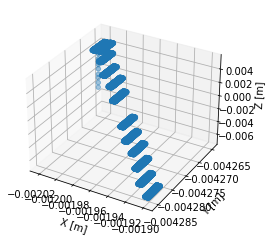

In [3]:
empty = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/empty.npy')
positions0 = np.load('/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/positions.npy')*1e-3
print(positions0)

folder_path = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/mogno/RHD_Salditt/multiZ/'
data_shape = (2048,2048)
n_points_per_z = 41*40
n_of_z = 12

# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(positions0[:,0],positions0[:,1],positions0[:,2],'o')
ax.set_xlabel('X [m]'), ax.set_ylabel('Y [m]'), ax.set_zlabel('Z [m]')
# plt.plot(positions0[:,0],positions0[:,1],'o')

z1z2 = 1

### Load data

Data #0 shape = (41, 40, 2048, 2048). 1640
Positions #0 shape = (1640, 3)
Data #1 shape = (41, 40, 2048, 2048). 1640
Positions #1 shape = (1640, 3)
Data #2 shape = (41, 40, 2048, 2048). 1640
Positions #2 shape = (1640, 3)


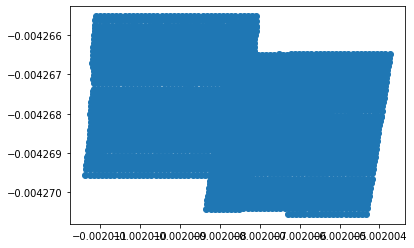

In [4]:
%matplotlib inline

A = 3 # wanted number of z positions

DPs_selected = np.empty((A*n_points_per_z,2048,2048),dtype=np.uint16)
positions_selected = np.empty((A*n_points_per_z,3))

for i in range(0,A):
    data = np.load(folder_path+f"z_{i}.npy")
    print(f"Data #{i} shape = {data.shape}. {data.shape[0]*data.shape[1]}")
    DP = data.reshape(n_points_per_z,data_shape[0],data_shape[1])
    positions1 = positions0[i*n_points_per_z:(i+1)*n_points_per_z]
    print(f"Positions #{i} shape = {positions1.shape}")    
   
    DPs_selected[i*n_points_per_z:(i+1)*n_points_per_z] = DP  
    positions_selected[i*n_points_per_z:(i+1)*n_points_per_z] = positions1
    
DPs_selected = np.delete(DPs_selected,range(1640,1640*2),axis=0)
positions_selected = np.delete(positions_selected,range(1640,1640*2),axis=0) 

DPs_selected = DPs_selected[20:] # remove first bad 
positions_selected = positions_selected[20:]

fig, ax = plt.subplots()
ax.plot(positions_selected[:,0],positions_selected[:,1],'o')

# for py,px in zip(positions_selected[:,0],positions_selected[:,1]):
#     point=(py,px)
#     rect = patches.Rectangle(point, 2048*1.44e-6, 2048*1.44e-6, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

In [5]:
# DPs_selected = DPs_selected[:,500:-500,500:-500]

In [6]:
# np.save('positions.npy',positions_selected)
# np.save('DPs_selected.npy',DPs_selected)
# DPs_selected = np.load('DPs_selected.npy')
# positions_selected = np.load('positions.npy')

DPs_selected.shape, positions_selected.shape,positions_selected    

((3260, 2048, 2048),
 (3260, 3),
 array([[-0.00200629, -0.00427055,  0.00527011],
        [-0.00200619, -0.00427055,  0.00527011],
        [-0.00200609, -0.00427055,  0.00527011],
        ...,
        [-0.0020073 , -0.00426552,  0.00327806],
        [-0.0020072 , -0.00426553,  0.00327806],
        [-0.00200709, -0.00426553,  0.00327806]]))

In [7]:
# fig, ax = plt.subplots(dpi=150)
# ax.imshow(DPs_selected[0])

In [8]:
# positions_selected = positions_selected[0:1620]
# DPs_selected = DPs_selected[0:1620]

### Call Ptychography

z1=0.005270114, z2=0.994729886, M=189.74921605111388
[[-0.00200629 -0.00427055  0.00527011]
 [-0.00200619 -0.00427055  0.00527011]
 [-0.00200609 -0.00427055  0.00527011]
 ...
 [-0.0020073  -0.00426552  0.00327806]
 [-0.0020072  -0.00426553  0.00327806]
 [-0.00200709 -0.00426553  0.00327806]]
Minimal required distance from focus = 1.742mm
Object pixel = 1.44e-06 m
Probe shape = (2048, 2048)
[8.000000e-09 6.000000e-09 4.000000e-09 ... 1.992050e-03 1.992049e-03
 1.992049e-03]
[189.74950409 189.74943208 189.74936007 ... 305.05810747 305.05801441
 305.05801441]
All positions:  (3260, 4)
Deleting 3060 slices


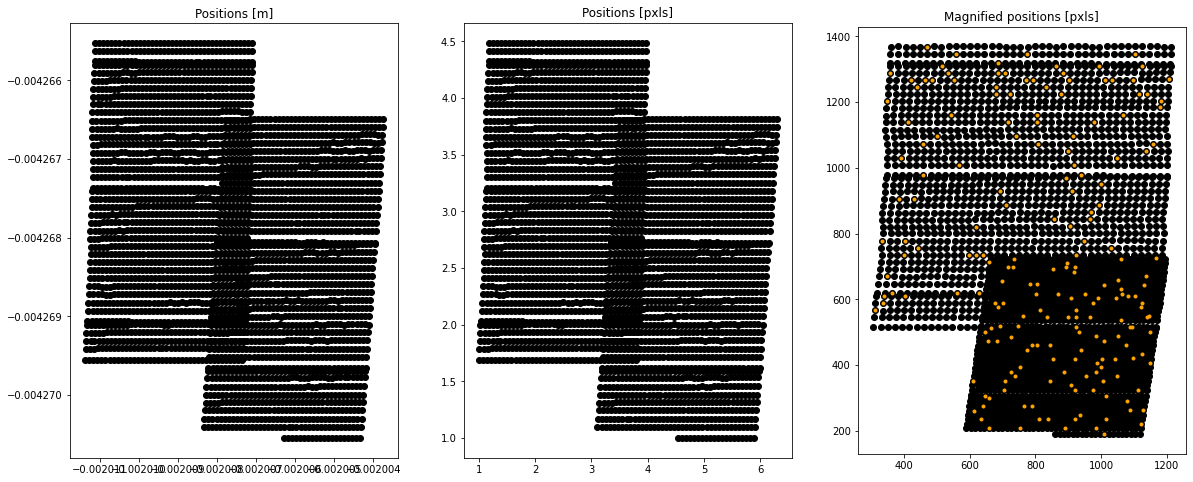

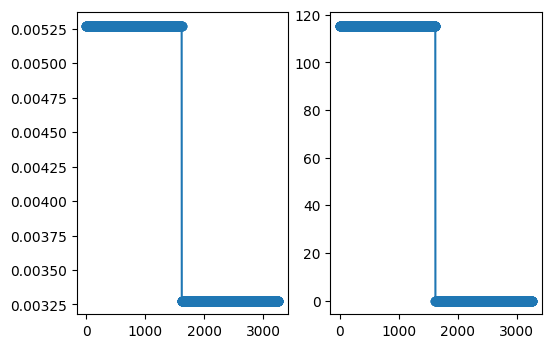

Size of the array: 1.5625 GB
Object shape = (3754, 3916)
FOV = [5405.76 5639.04] um2
Data shape = (200, 2048, 2048)
Positions shape = (200, 4)
(200, 4) (200, 2048, 2048) (2048, 2048) (3754, 3916) {'n_cpus': 32, 'energy': 22, 'detector_position': 188.74921605111388, 'detector_distance': -0.0, 'detector_pixel_size': 1.44e-06, 'source_distance': 0, 'wavelength': 5.6356453357367875e-11, 'object_pixel': 1.44e-06, 'object_padding': 1, 'object_shape': (3754, 3916), 'iterations': 1, 'fresnel_regime': True, 'probe_support': None, 'probe_support_array': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint16), 'incoherent_modes': 1, 'beta': 0.9, 'epsilon': 0.001, 'regularization_object': 0.25, 'regularization_probe': 0.5, 'step_object': 0.5, 'step_probe': 1, 'use_mPIE': False, 'friction_object': 0.9, 'friction_probe': 0.99, 'momentum_co

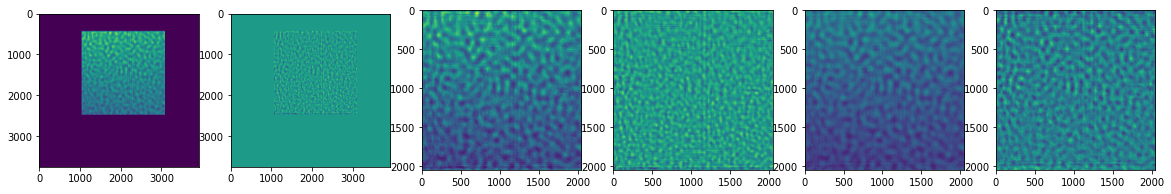

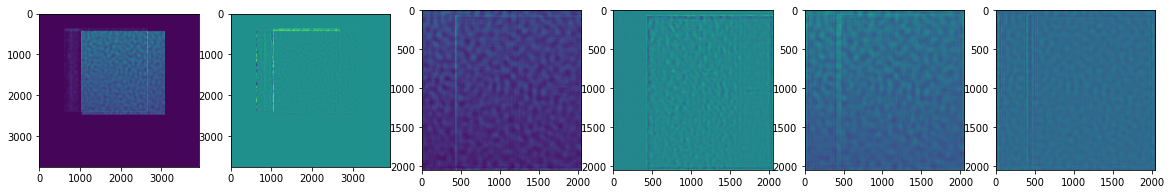

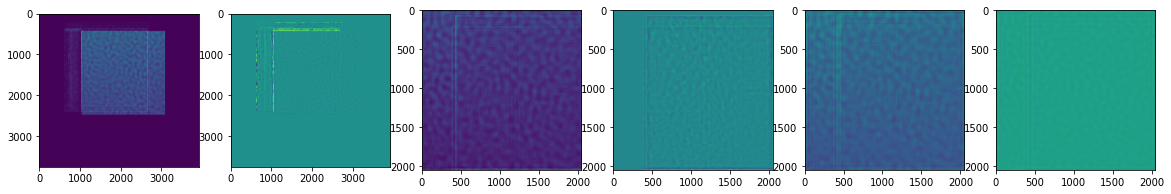

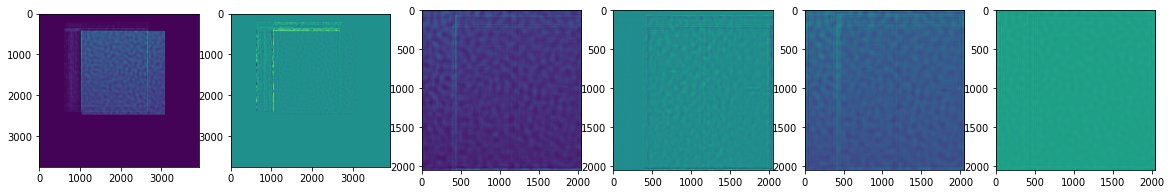

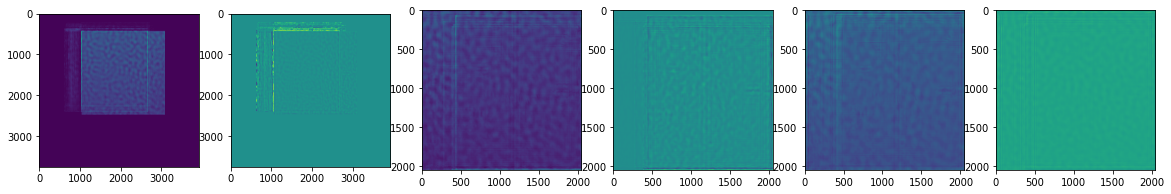

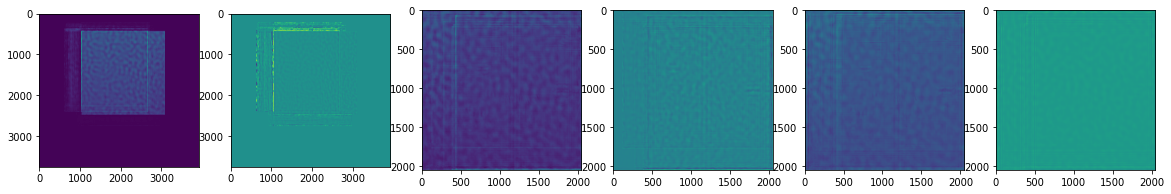

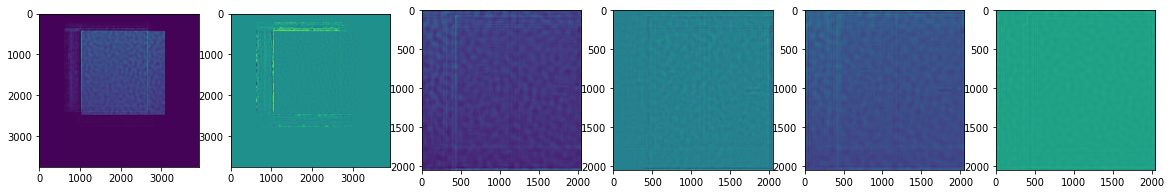

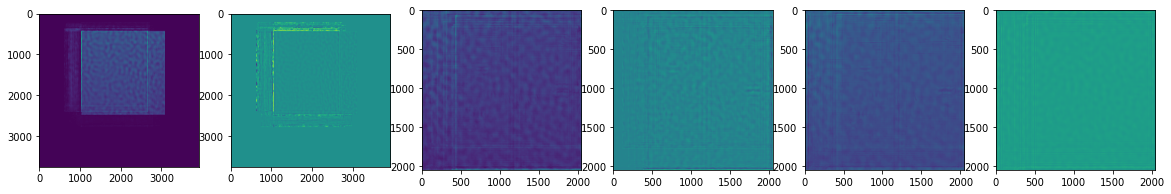

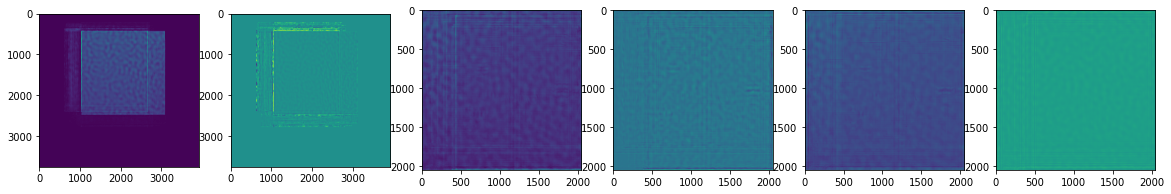

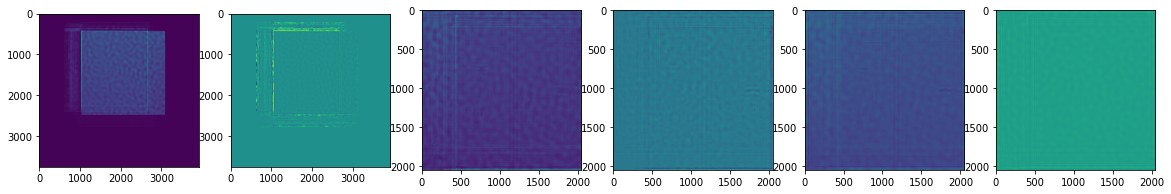

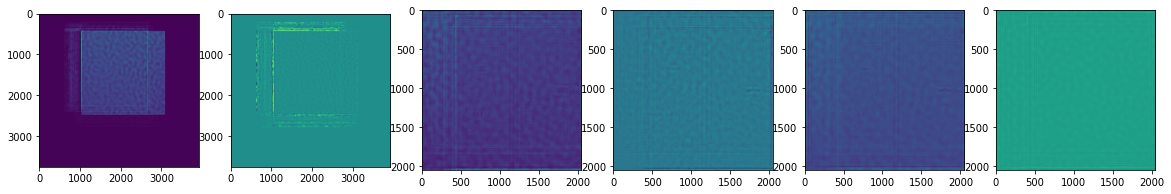

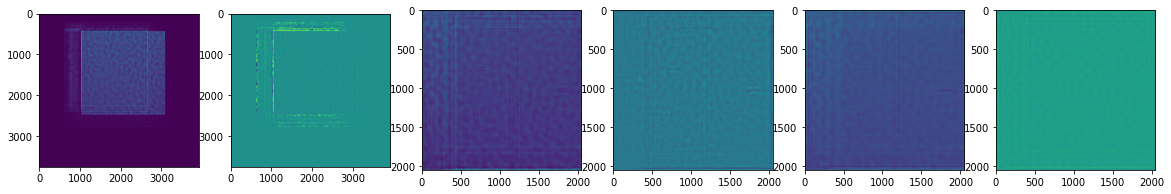

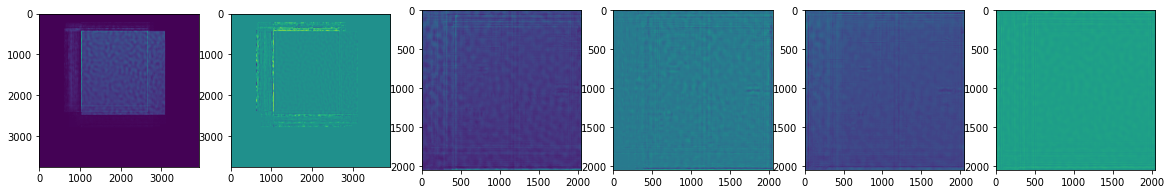

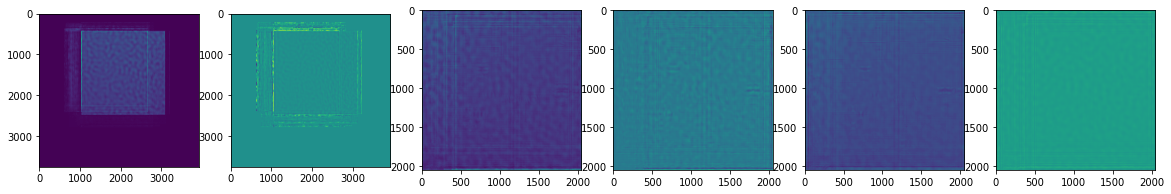

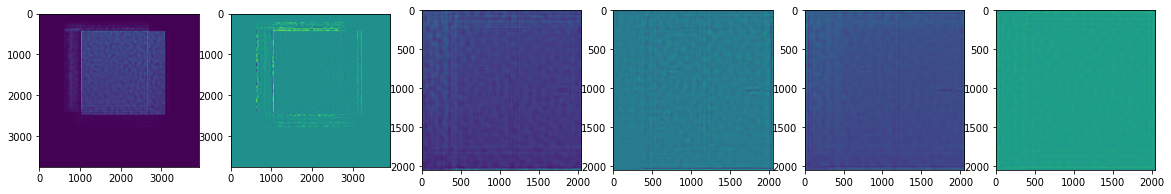

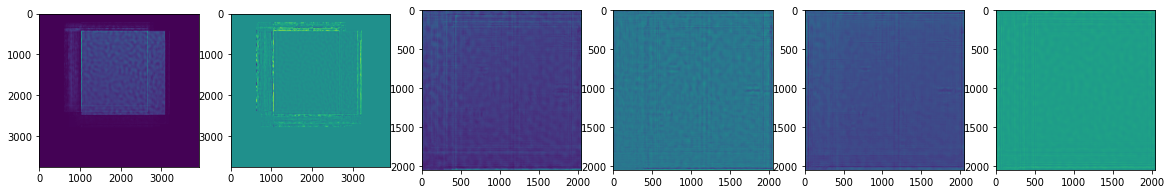

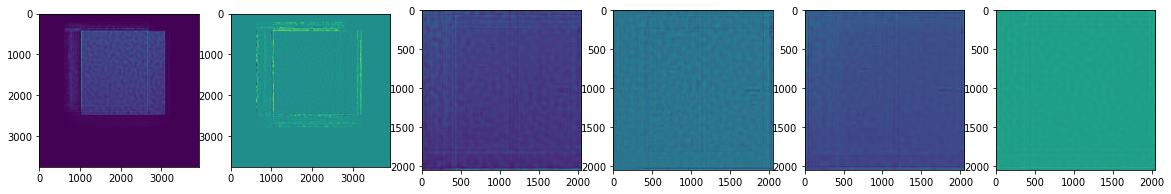

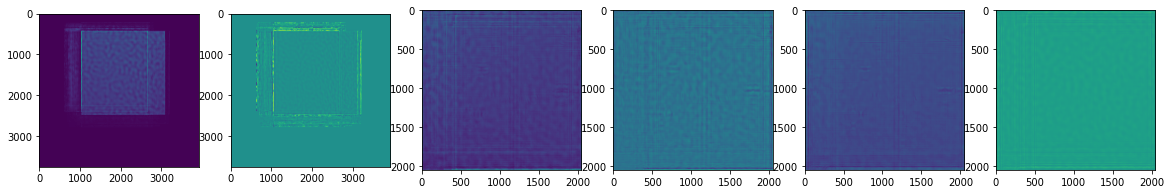

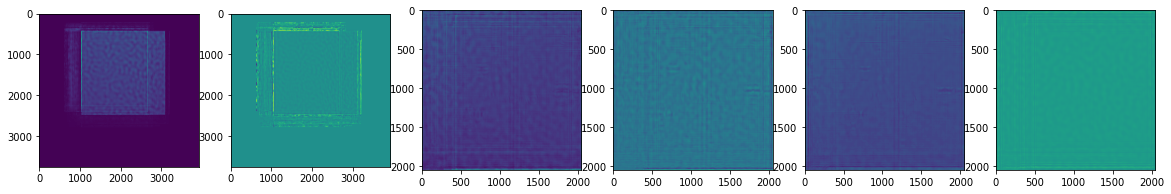

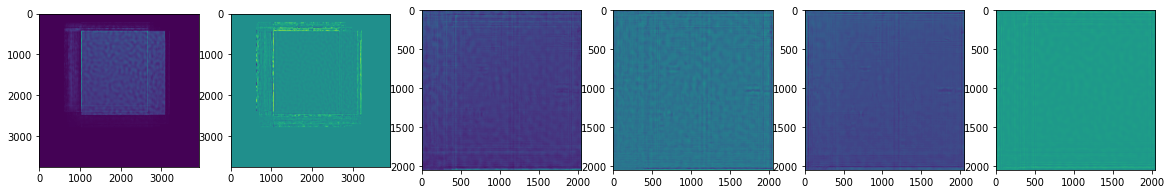

In [ ]:
%matplotlib inline

try:
    import cupy as cp
    cp.cuda.memory.MemoryPool().free_all_blocks()
except:
    print('exception')
    
positions = positions_selected.copy()

z1 = np.max(positions0[:,2])
z2 = 1 - z1
M0 = (z2+z1)/z1
print(f'z1={z1}, z2={z2}, M={M0}')

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
n_pixels = 2048

inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_position": z2*M0,    
"detector_distance": z2*M0,    
"detector_pixel_size": 1.44e-6, # PCO pixel size with lens 
"source_distance": 0, # should be 0 if parallel beam
}

# positions[:,0:2] *= M0
print(positions)

wavelength = c_speed * planck / inputs["energy"]
inputs["wavelength"] = wavelength

waist = 250e-9/2
zmin = 2*np.pi*waist**2/wavelength
print(f'Minimal required distance from focus = {zmin*1e3:.3f}mm')

inputs['object_pixel'] = inputs["detector_pixel_size"]
print(f'Object pixel = {inputs["object_pixel"]} m')


probe = np.ones_like(DPs_selected[0])
print(f'Probe shape = {probe.shape}')

fig, ax = plt.subplots(1,3,figsize=(20,8))
ax[0].plot(positions[:,0],positions[:,1],'o',color='black')
ax[0].set_title('Positions [m]')

inputs["object_padding"] = 1
positions[:,0:2] = convert_probe_mogno_positions_meters_to_pixels(positions[:,0:2].copy(),inputs["object_pixel"],inputs["object_padding"])

ax[1].plot(positions[:,0],positions[:,1],'o',color='black')
ax[1].set_title('Positions [pxls]')

fig2, ax2 = plt.subplots(1,2,dpi=100)
ax2[0].plot(positions[:,2],'o-',)
positions, new_detector_position = get_equivalent_geometry(positions,z1z2)
inputs["detector_distance"] = new_detector_position
ax2[1].plot(positions[:,2],'o-')
positions[:,3] = np.round(positions[:,3])
print('All positions: ', positions.shape)
ax[2].plot(positions[:,0],positions[:,1],'o',color='black')

if 1: # remove random points from data
    n_of_points_to_keep = 200
    start_idx = positions.shape[0] - n_of_points_to_keep
    slices_to_ignore = np.random.permutation(positions.shape[0])[-start_idx::]
    print(f'Deleting {slices_to_ignore.shape[0]} slices')
    positions = np.delete(positions,slices_to_ignore,axis=0)
    DPs = np.delete(DPs_selected,slices_to_ignore,axis=0)

ax[2].plot(positions[:,0],positions[:,1],'.',color='orange')
ax[2].set_title('Magnified positions [pxls]')
ax[2].set_aspect('equal')
# for py,px in zip(positions[:,0],positions[:,1]):
    # point=(py,px)
    # rect = patches.Rectangle(point, 2048, -2048, linewidth=1, edgecolor='r', facecolor='none')
    # ax[2].add_patch(rect)
plt.show()

size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

object_padding = 500
inputs["object_shape"] = sscCdi.set_object_shape(object_padding, DPs.shape, positions[:,0:2])
# inputs["object_shape"] = (inputs["object_shape"][1],inputs["object_shape"][0])
print(f'Object shape = {inputs["object_shape"]}')
print(f'FOV = {np.asarray(inputs["object_shape"])*inputs["object_pixel"]*1e6} um2')
print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
# probe_guess = DPs.mean(0)
obj_guess = np.ones_like(model_object) # constant object

inputs['iterations'] = 1   
inputs["fresnel_regime"] = True
inputs["probe_support"] = None
inputs["probe_support_array"] = np.ones_like(probe)
inputs["incoherent_modes"] = 1
inputs['beta'] = 0.9 # RAAR
inputs['epsilon'] = 0.001 # RAAR; small value to add to probe/object update denominator


inputs['regularization_object'] = 0.25
inputs['regularization_probe'] = 0.5
inputs['step_object'] = 0.5
inputs['step_probe'] = 1
inputs['use_mPIE'] = False
inputs['friction_object'] = 0.9
inputs['friction_probe'] = 0.99
inputs['momentum_counter'] = 10
inputs['distance_sample_focus']=inputs["source_distance"]
    

DPs = DPs[::-1]
positions = positions[::-1]

print(positions.shape, DPs.shape, probe_guess.shape, obj_guess.shape, inputs)
# RAAR_obj, RAAR_probes, _ = RAAR_multiplane(DPs,positions,obj_guess,probe_guess,inputs)


for plane_number in range(0,1+int(positions[:,3].max())): # ptycho at plane z

    print(f"\tPtycho @ plane #{plane_number}")

    positions_current_plane = positions[positions[:,3]==plane_number] # get positions only for desired z-plane
    data_current_plane = DPs[positions[:,3]==plane_number] # get DP only for desired z-plane

    inputs["detector_distance"] = inputs["detector_position"] - positions_current_plane[0,2] # new distance between sample and detector  
    RAAR_obj, RAAR_probes, _ = PIE_multiprobe_loop(data_current_plane, positions_current_plane, obj_guess, probe_guess, inputs)

    propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"])
    
    obj_guess, probe_guess = RAAR_obj, RAAR_probes[0]

    if 1: # plot
        fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
        im1=ax[0,0].imshow(np.abs(RAAR_obj))
        ax[0,0].set_title('Obj Mag')
        # ax[0,0].plot(positions[:,0],positions[:,1],'.',color='gray')
        fig.colorbar(im1, ax=ax[0, 0])

        im2 = ax[1,0].imshow(np.angle(RAAR_obj))
        ax[1,0].set_title('Obj Phase')
        fig.colorbar(im2, ax=ax[1, 0])

        im3 = ax[0,1].imshow(np.abs(RAAR_probes[0]))
        ax[0,1].set_title('Probe Mag')
        fig.colorbar(im3, ax=ax[0, 1])

        im4 = ax[1,1].imshow(np.angle(RAAR_probes[0]))
        ax[1,1].set_title('Probe Phase')
        fig.colorbar(im4, ax=ax[1, 1])

        im5=ax[0,2].imshow(np.abs(propagated_probe))
        ax[0,2].set_title('Mag @ Detector')
        fig.colorbar(im5, ax=ax[0, 2])

        mean = np.mean(np.angle(propagated_probe))
        std=np.std(np.angle(propagated_probe))
        im6 = ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std)
        ax[1,2].set_title('Phase @ Detector')
        fig.colorbar(im6, ax=ax[1,2])

        fig.suptitle('Tim Salditt RHD sample - Near-field Ptychography')

        for i, ax in enumerate(ax.ravel()):
            if i==3 or i==0 or i ==4: continue
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()

